# Data extraction and aggregation

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

path = r'./../data/UNSW-NB15/'

features = pd.read_csv(path + "NUSW-NB15_features.csv", encoding='cp1252')

data = pd.concat([
    pd.read_csv(path + "UNSW-NB15_1.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_2.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_3.csv", low_memory=False, names=features.Name),
    pd.read_csv(path + "UNSW-NB15_4.csv", low_memory=False, names=features.Name)
])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit           

# Features Conversion

## Features which are unusable in the real world are dropped

the features are : `srcip`, `sport`, `dstip`

`srcip` and `srcport` can vary based on the client and they can be faked using vpns. `dstip` can vary depending on the hosting server. 

So there features have no meaning in a broader scenario.

In [3]:
data.drop(columns=["srcip", "sport", "dstip"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            object 
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Parsing non trivial features



In [4]:
# convert a blank space to `-1`
data["ct_ftp_cmd"] = data["ct_ftp_cmd"].apply(lambda x: int(x) if x != " " else -1)
# convert hex to int
data["dsport"] = data["dsport"].apply(lambda x: int(x, 16) if x != "-" else -1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            int64  
 1   proto             object 
 2   state             object 
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           object 
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

## Setting `Nan` to `-1`

In [5]:
data["ct_flw_http_mthd"].fillna(-1,  inplace=True)
data["is_ftp_login"].fillna(-1,  inplace=True)

## Converting the nominal features

In these case the `pd.factorize` is utilized and the relation between the `` and the old ones is displayed using dictionaries 

In [6]:
nominal_features = ["proto", "state", "service"]

for nominal_feature in nominal_features:
	new_values, index = pd.factorize(data[nominal_feature])
	data[nominal_feature] = new_values

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dsport            int64  
 1   proto             int64  
 2   state             int64  
 3   dur               float64
 4   sbytes            int64  
 5   dbytes            int64  
 6   sttl              int64  
 7   dttl              int64  
 8   sloss             int64  
 9   dloss             int64  
 10  service           int64  
 11  Sload             float64
 12  Dload             float64
 13  Spkts             int64  
 14  Dpkts             int64  
 15  swin              int64  
 16  dwin              int64  
 17  stcpb             int64  
 18  dtcpb             int64  
 19  smeansz           int64  
 20  dmeansz           int64  
 21  trans_depth       int64  
 22  res_bdy_len       int64  
 23  Sjit              float64
 24  Djit              float64
 25  Stime             int64  
 26  Ltime          

# Data reduction

## Binary classication distribution

In [7]:
data_summary_attack = pd.DataFrame(data.Label.value_counts())
data_summary_attack.columns.values[0] = "Occurrencies"

data_summary_attack["Percentage"] = data.Label.value_counts() / len(data)

data_summary_attack

,Occurrencies,Percentage
0,2218764,0.873513
1,321283,0.126487


We have a very unbalanced dataset. Now let's look at the attack classes

## Multiclass classificatin distribution

In [8]:
data_summary_classes = pd.DataFrame(data.attack_cat.value_counts())
data_summary_classes.columns.values[0] = "Occurrencies"

attack_len = sum(data.Label)
data_summary_classes["Percentage"] = data.attack_cat.value_counts() / attack_len

data_summary_classes

,Occurrencies,Percentage
Generic,215481,0.670689
Exploits,44525,0.138585
Fuzzers,19195,0.059745
DoS,16353,0.050899
Reconnaissance,12228,0.038060
Fuzzers,5051,0.015721
Analysis,2677,0.008332
Backdoor,1795,0.005587
Reconnaissance,1759,0.005475
Shellcode,1288,0.004009


also the classes of attack are very unbalanced

## Reduce the number of classes of attack

Let's first see the clusterability of the data set

In [9]:
import pyclustertend as pyct

#Calculating the clusterability of the data frame in multiple samples
data2 = data[data["attack_cat"] != 'nan'].dropna().drop_duplicates()
avg_list = []
for sampling_size in range(10,51,10):
    sample_list = []
    for i in range(1,10,1):
        data_blob = data2.drop(columns=["Label", "attack_cat"]).sample(20_000)
        sample_list.append(pyct.hopkins(data_blob,sampling_size))
    print(f'Sampled {sampling_size}: {sum(sample_list) / len(sample_list)}')

Sampled 10: 0.006239772671293353
Sampled 20: 0.005230800173403262
Sampled 30: 0.006167983170304304
Sampled 40: 0.005233725570022781
Sampled 50: 0.004660606441533491


The value is close to 0, so the dataset is very clusterable

## Data is clustered using k-means

<Figure size 640x480 with 0 Axes>

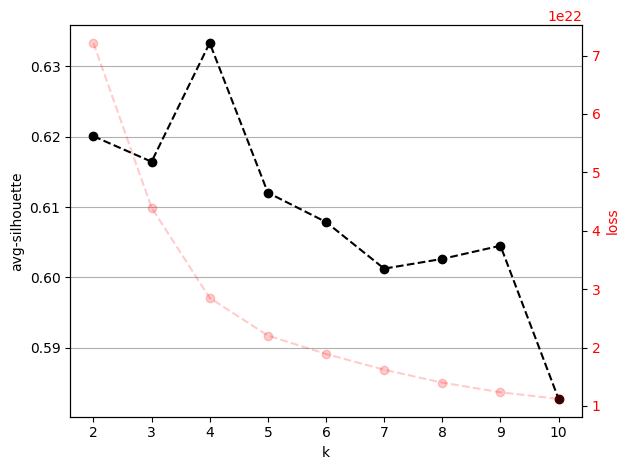

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

to_plot = data[data["attack_cat"] != 'nan'].dropna().drop_duplicates()

to_plot = to_plot.drop(columns=["Label", "attack_cat"]).sample(50_000)

#to_plot = StandardScaler().fit_transform(to_plot)

silhouette_list = []
inertia_list=[]

for n_clusters in range(2,11):
    kmeans = KMeans(n_clusters=n_clusters)
    y_pred = kmeans.fit_predict(to_plot)

    # evaluate silhouette score
    silhouetteavg = silhouette_score(to_plot,y_pred)
    silhouette_list.append(silhouetteavg)

    # evaluate inertia
    inertia_list.append(kmeans.inertia_)


plt.tight_layout()

# plot silhouette and inertia trends w.r.t the number of clusters
fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('avg-silhouette', color='black')
ax1.plot(range(2,11),silhouette_list,'--ok')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('loss', color='red')
ax2.plot(range(2,11), inertia_list,'--or',alpha = 0.2)
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

Using the silhouette method we have that the optimal number of clusters is 4-ish and 6-ish for only the attack categories, let's print the info of each cluster

In [11]:
# data_cluster = data[data["attack_cat"] != 'nan'].drop(columns="Label").dropna().sample(50_000)
data_cluster = data[data["attack_cat"] != 'nan'].drop(columns="Label").dropna().drop_duplicates()
data_cluster.attack_cat = data_cluster.attack_cat.apply(lambda x: x.strip())
data_cluster.attack_cat = data_cluster.attack_cat.apply(lambda x: "Backdoor" if x == "Backdoors" else x)

# Clustering with 4 clusters
cluster1 = KMeans(n_clusters = 4)
data_cluster["cluster"] = cluster1.fit_predict(data_cluster.drop(columns="attack_cat"))

# conta il numero di elementi in ogni cluster
counts = data_cluster.groupby('cluster')['attack_cat'].value_counts()

#counts_df = pd.DataFrame(counts)
table = pd.DataFrame()
for i in range(0,4):
    table["C " + str(i)] = pd.DataFrame(counts[i])

# print(table)
# print(table.div(table.sum(axis=0), axis=1).round(4) * 100)
print(table.div(table.sum(axis=1), axis=0).round(4) * 100)

# Clustering with 7 clusters
cluster2 = KMeans(n_clusters = 7)
data_cluster["cluster"] = cluster2.fit_predict(data_cluster.drop(columns="attack_cat"))

# conta il numero di elementi in ogni cluster
counts = data_cluster.groupby('cluster')['attack_cat'].value_counts()

#counts_df = pd.DataFrame(counts)
table = pd.DataFrame()
for i in range(0,7):
    table["C " + str(i)] = pd.DataFrame(counts[i])

# print(table)
# print(table.div(table.sum(axis=0), axis=1).round(4) * 100)
print(table.div(table.sum(axis=1), axis=0).round(4) * 100)

# Clustering with 9 clusters
cluster3 = KMeans(n_clusters = 9)
data_cluster["cluster"] = cluster3.fit_predict(data_cluster.drop(columns="attack_cat"))

# conta il numero di elementi in ogni cluster
counts = data_cluster.groupby('cluster')['attack_cat'].value_counts()

#counts_df = pd.DataFrame(counts)
table = pd.DataFrame()
for i in range(0,9):
    table["C " + str(i)] = pd.DataFrame(counts[i])

# print(table)
# print(table.div(table.sum(axis=0), axis=1).round(4) * 100)
print(table.div(table.sum(axis=1), axis=0).round(4) * 100)

# Clustering with 15 clusters
cluster4 = KMeans(n_clusters = 15)
data_cluster["cluster"] = cluster4.fit_predict(data_cluster.drop(columns="attack_cat"))

# conta il numero di elementi in ogni cluster
counts = data_cluster.groupby('cluster')['attack_cat'].value_counts()

#counts_df = pd.DataFrame(counts)
table = pd.DataFrame()
for i in range(0,15):
    table["C " + str(i)] = pd.DataFrame(counts[i])

# print(table)
# print(table.div(table.sum(axis=0), axis=1).round(4) * 100)
print(table.div(table.sum(axis=1), axis=0).round(4) * 100)


                  C 0    C 1    C 2    C 3
attack_cat                                
Generic         89.25   3.70   3.13   3.93
Fuzzers         41.20  21.09  16.99  20.72
Reconnaissance  54.15  16.54  13.61  15.70
Exploits        20.02  28.47  23.81  27.69
DoS             48.47  18.08  14.95  18.50
Analysis        81.18   6.59   5.22   7.01
Backdoor        85.63   4.89   4.24   5.24
Shellcode       56.32  15.16  12.64  15.88
Worms           22.22  19.88  19.88  38.01
                  C 0    C 1    C 2    C 3    C 4    C 5    C 6
attack_cat                                                     
Exploits        12.49  14.32  16.45  15.20  13.57  13.73  14.23
Fuzzers          9.38  36.82  11.92  11.06  10.66   9.93  10.24
Reconnaissance   7.35  50.81   9.18   8.60   8.06   7.78   8.22
DoS              8.10  45.08  10.52   9.55   9.21   8.53   9.00
Generic          1.59  88.47   2.42   1.93   1.89   1.78   1.91
Shellcode        7.81  52.88   9.66   8.74   7.74   5.76   7.41
Analysis       

[Shellcode] and [Reconnaissance] act similarly, the same goes for [Fuzzers] and [DoS], then [Analysis] and [Backdoor]. Then the [Worms] class can be eliminated because of the too few examples

we can see that the classes of attack are reduced to [Shellcode/Reconnaissance], [Fuzzers/DoS], [Analysis/Backdoor], [Generic] and [Exploits]

In [12]:
data_reduced = data[data['attack_cat'] != 'nan'].dropna().drop_duplicates()
data_reduced = data_reduced[data_reduced['attack_cat'] != 'Worms']
# print(data_reduced)

data_reduced.attack_cat = data_reduced.attack_cat.apply(lambda x: str(x).strip())
data_reduced.attack_cat = data_reduced.attack_cat.apply(lambda x: "Shellcode/Reconnaissance" if x == "Shellcode" or x == "Reconnaissance" else x)
data_reduced.attack_cat = data_reduced.attack_cat.apply(lambda x: "Fuzzers/DoS" if x == "Fuzzers" or x == "DoS" else x)
data_reduced.attack_cat = data_reduced.attack_cat.apply(lambda x: "Analysis/Backdoor" if x == "Analysis" or x == "Backdoor" or x == "Backdoors" else x)

data_summary_classes = pd.DataFrame(data_reduced.attack_cat.value_counts())
data_summary_classes.columns.values[0] = "Occurrencies"

# attack_len = sum(data.Label)
data_summary_classes["Percentage"] = data_reduced.attack_cat.value_counts() / len(data_reduced)

data_summary_classes
# len(data_reduced)

,Occurrencies,Percentage
Exploits,27599,0.278151
Fuzzers/DoS,27307,0.275208
Generic,25285,0.254830
Shellcode/Reconnaissance,14865,0.149814
Analysis/Backdoor,4167,0.041996


## Adding non attack rows

In [13]:
data = pd.concat([data_reduced,data[data.Label == 0].sample(100_000)])

## Plot the features correlation

C:\Users\aless\AppData\Local\Temp\ipykernel_18984\3893306067.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_without_label.corr()


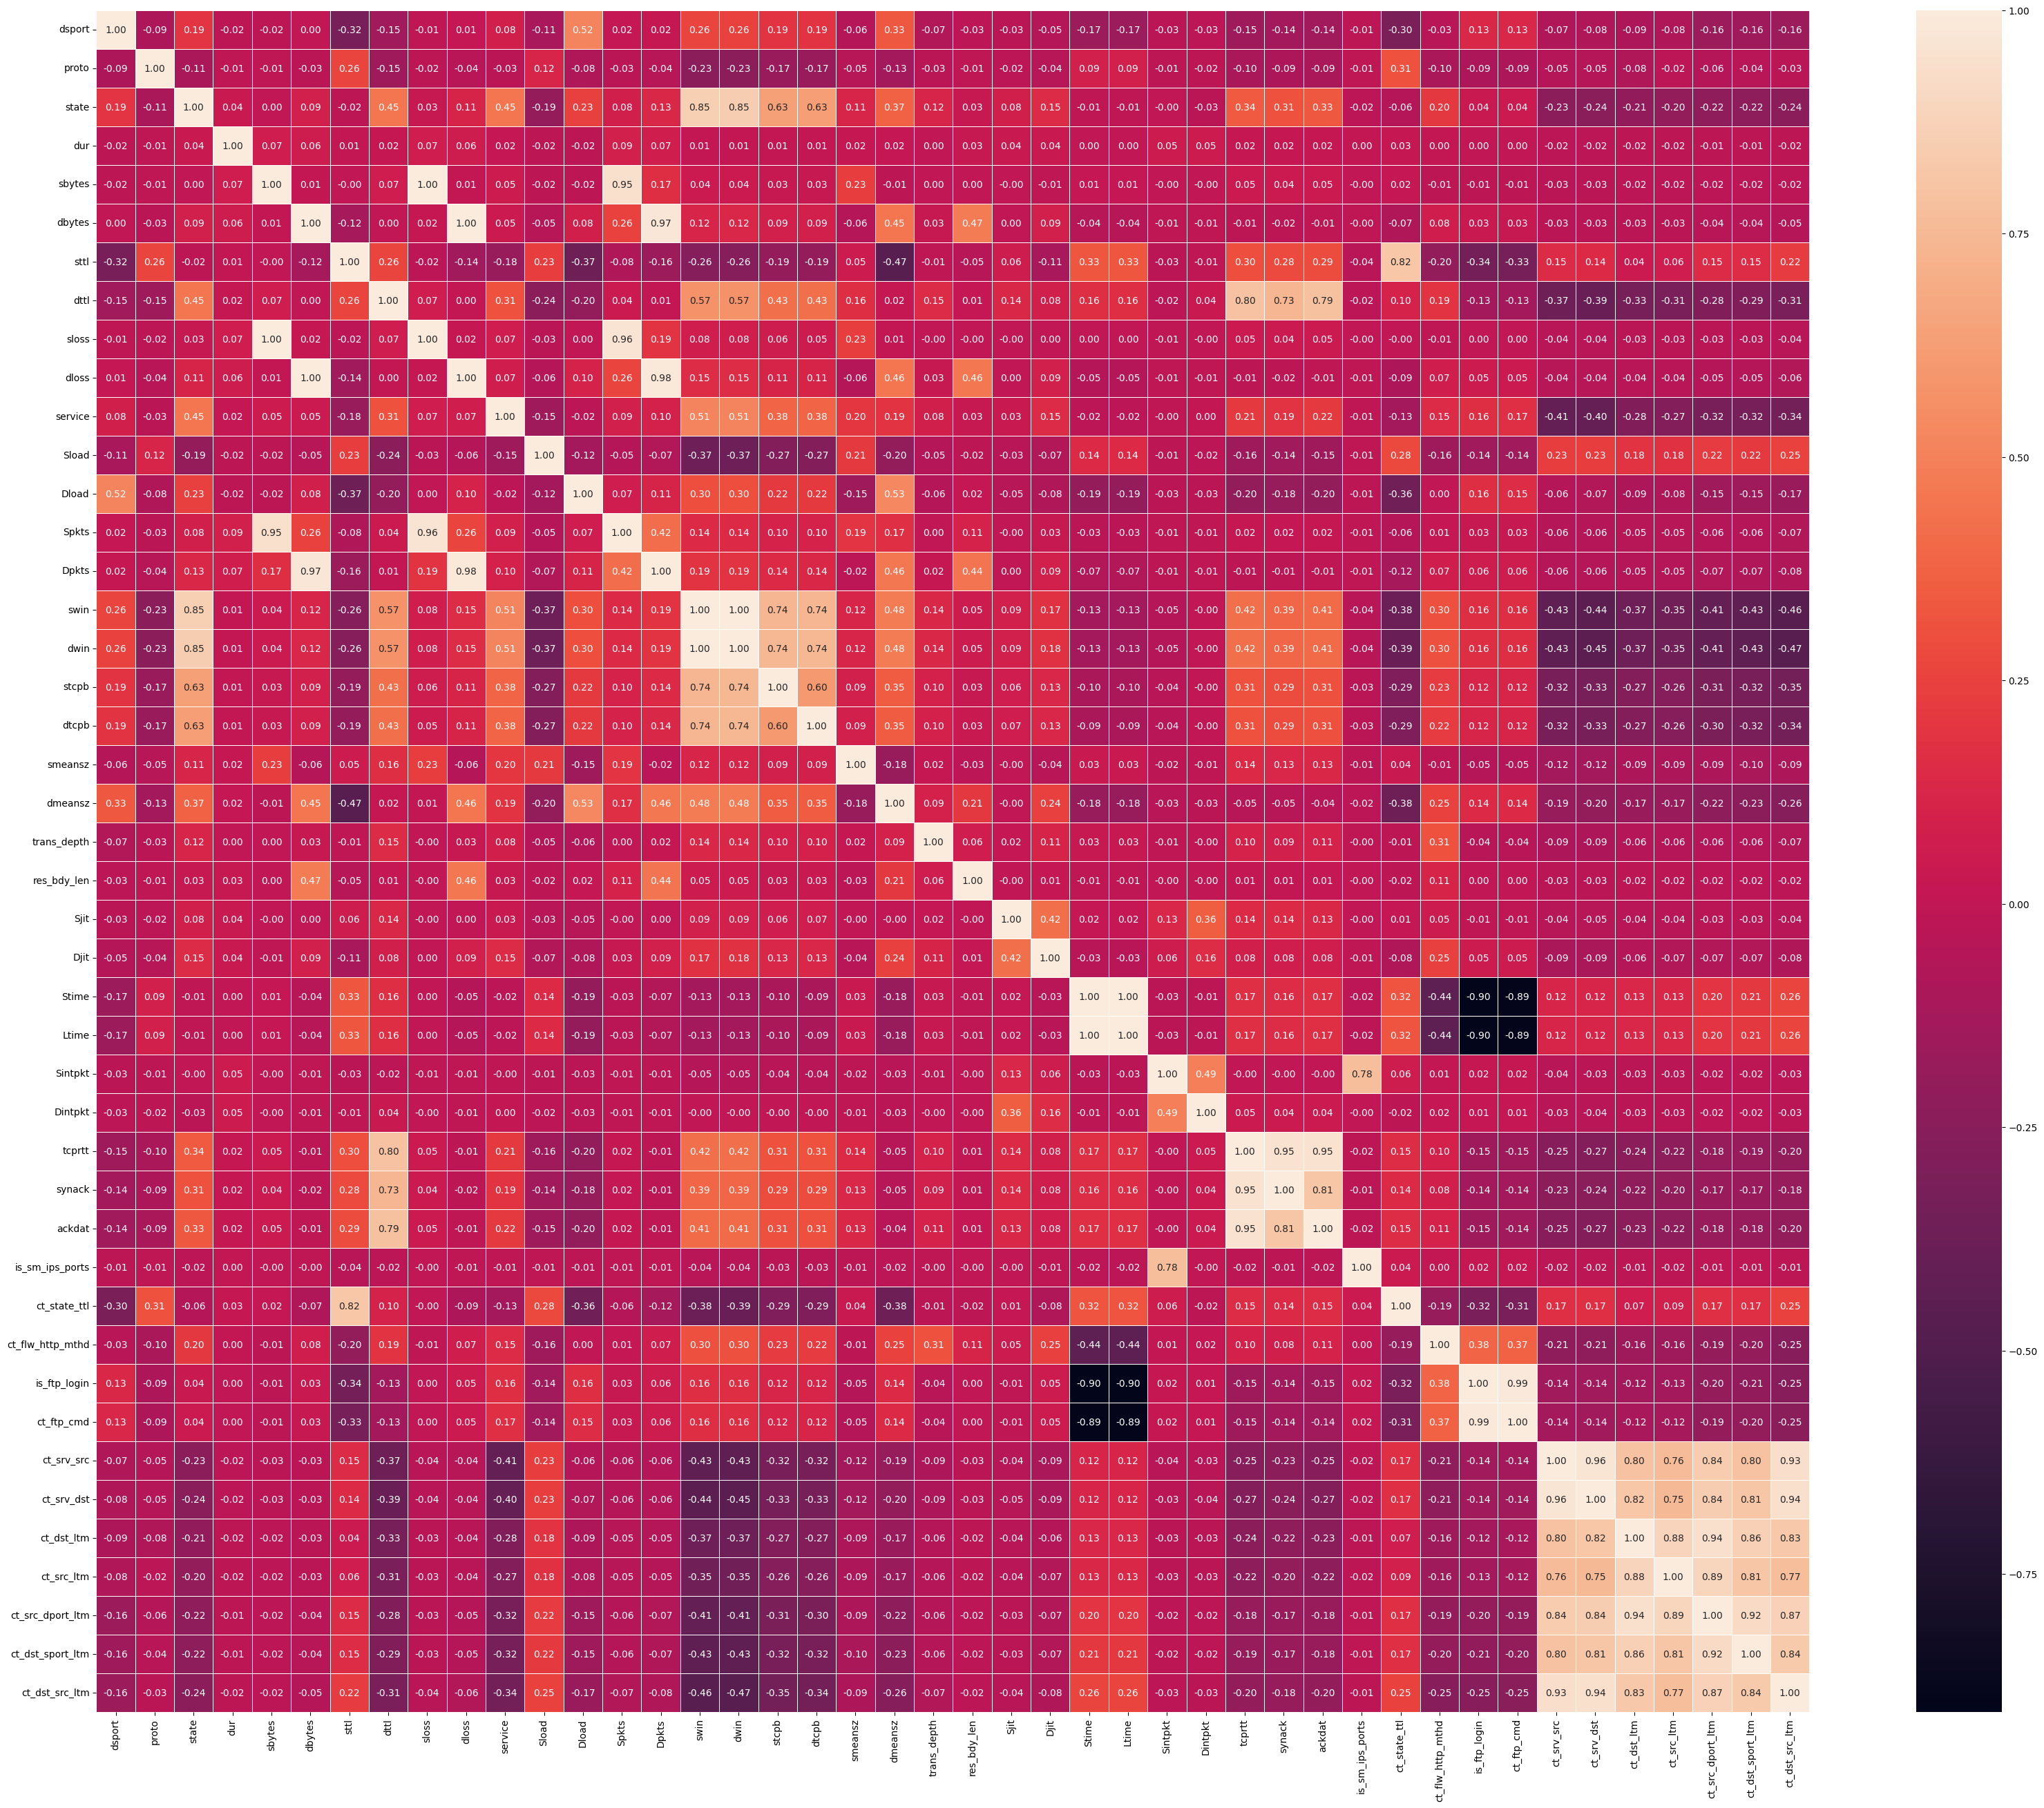

In [14]:
f,ax = plt.subplots(figsize=(40,32))

data_without_label = data.drop(columns=['Label'])

correlation_matrix = data_without_label.corr()

sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

Drop the over-correlated features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199223 entries, 20 to 252672
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   dsport            199223 non-null  int64  
 1   proto             199223 non-null  int64  
 2   state             199223 non-null  int64  
 3   dur               199223 non-null  float64
 4   sbytes            199223 non-null  int64  
 5   dbytes            199223 non-null  int64  
 6   sttl              199223 non-null  int64  
 7   dttl              199223 non-null  int64  
 8   service           199223 non-null  int64  
 9   Sload             199223 non-null  float64
 10  Dload             199223 non-null  float64
 11  swin              199223 non-null  int64  
 12  stcpb             199223 non-null  int64  
 13  dtcpb             199223 non-null  int64  
 14  smeansz           199223 non-null  int64  
 15  dmeansz           199223 non-null  int64  
 16  trans_depth       1

C:\Users\aless\AppData\Local\Temp\ipykernel_18984\3337227.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_without_label.corr()


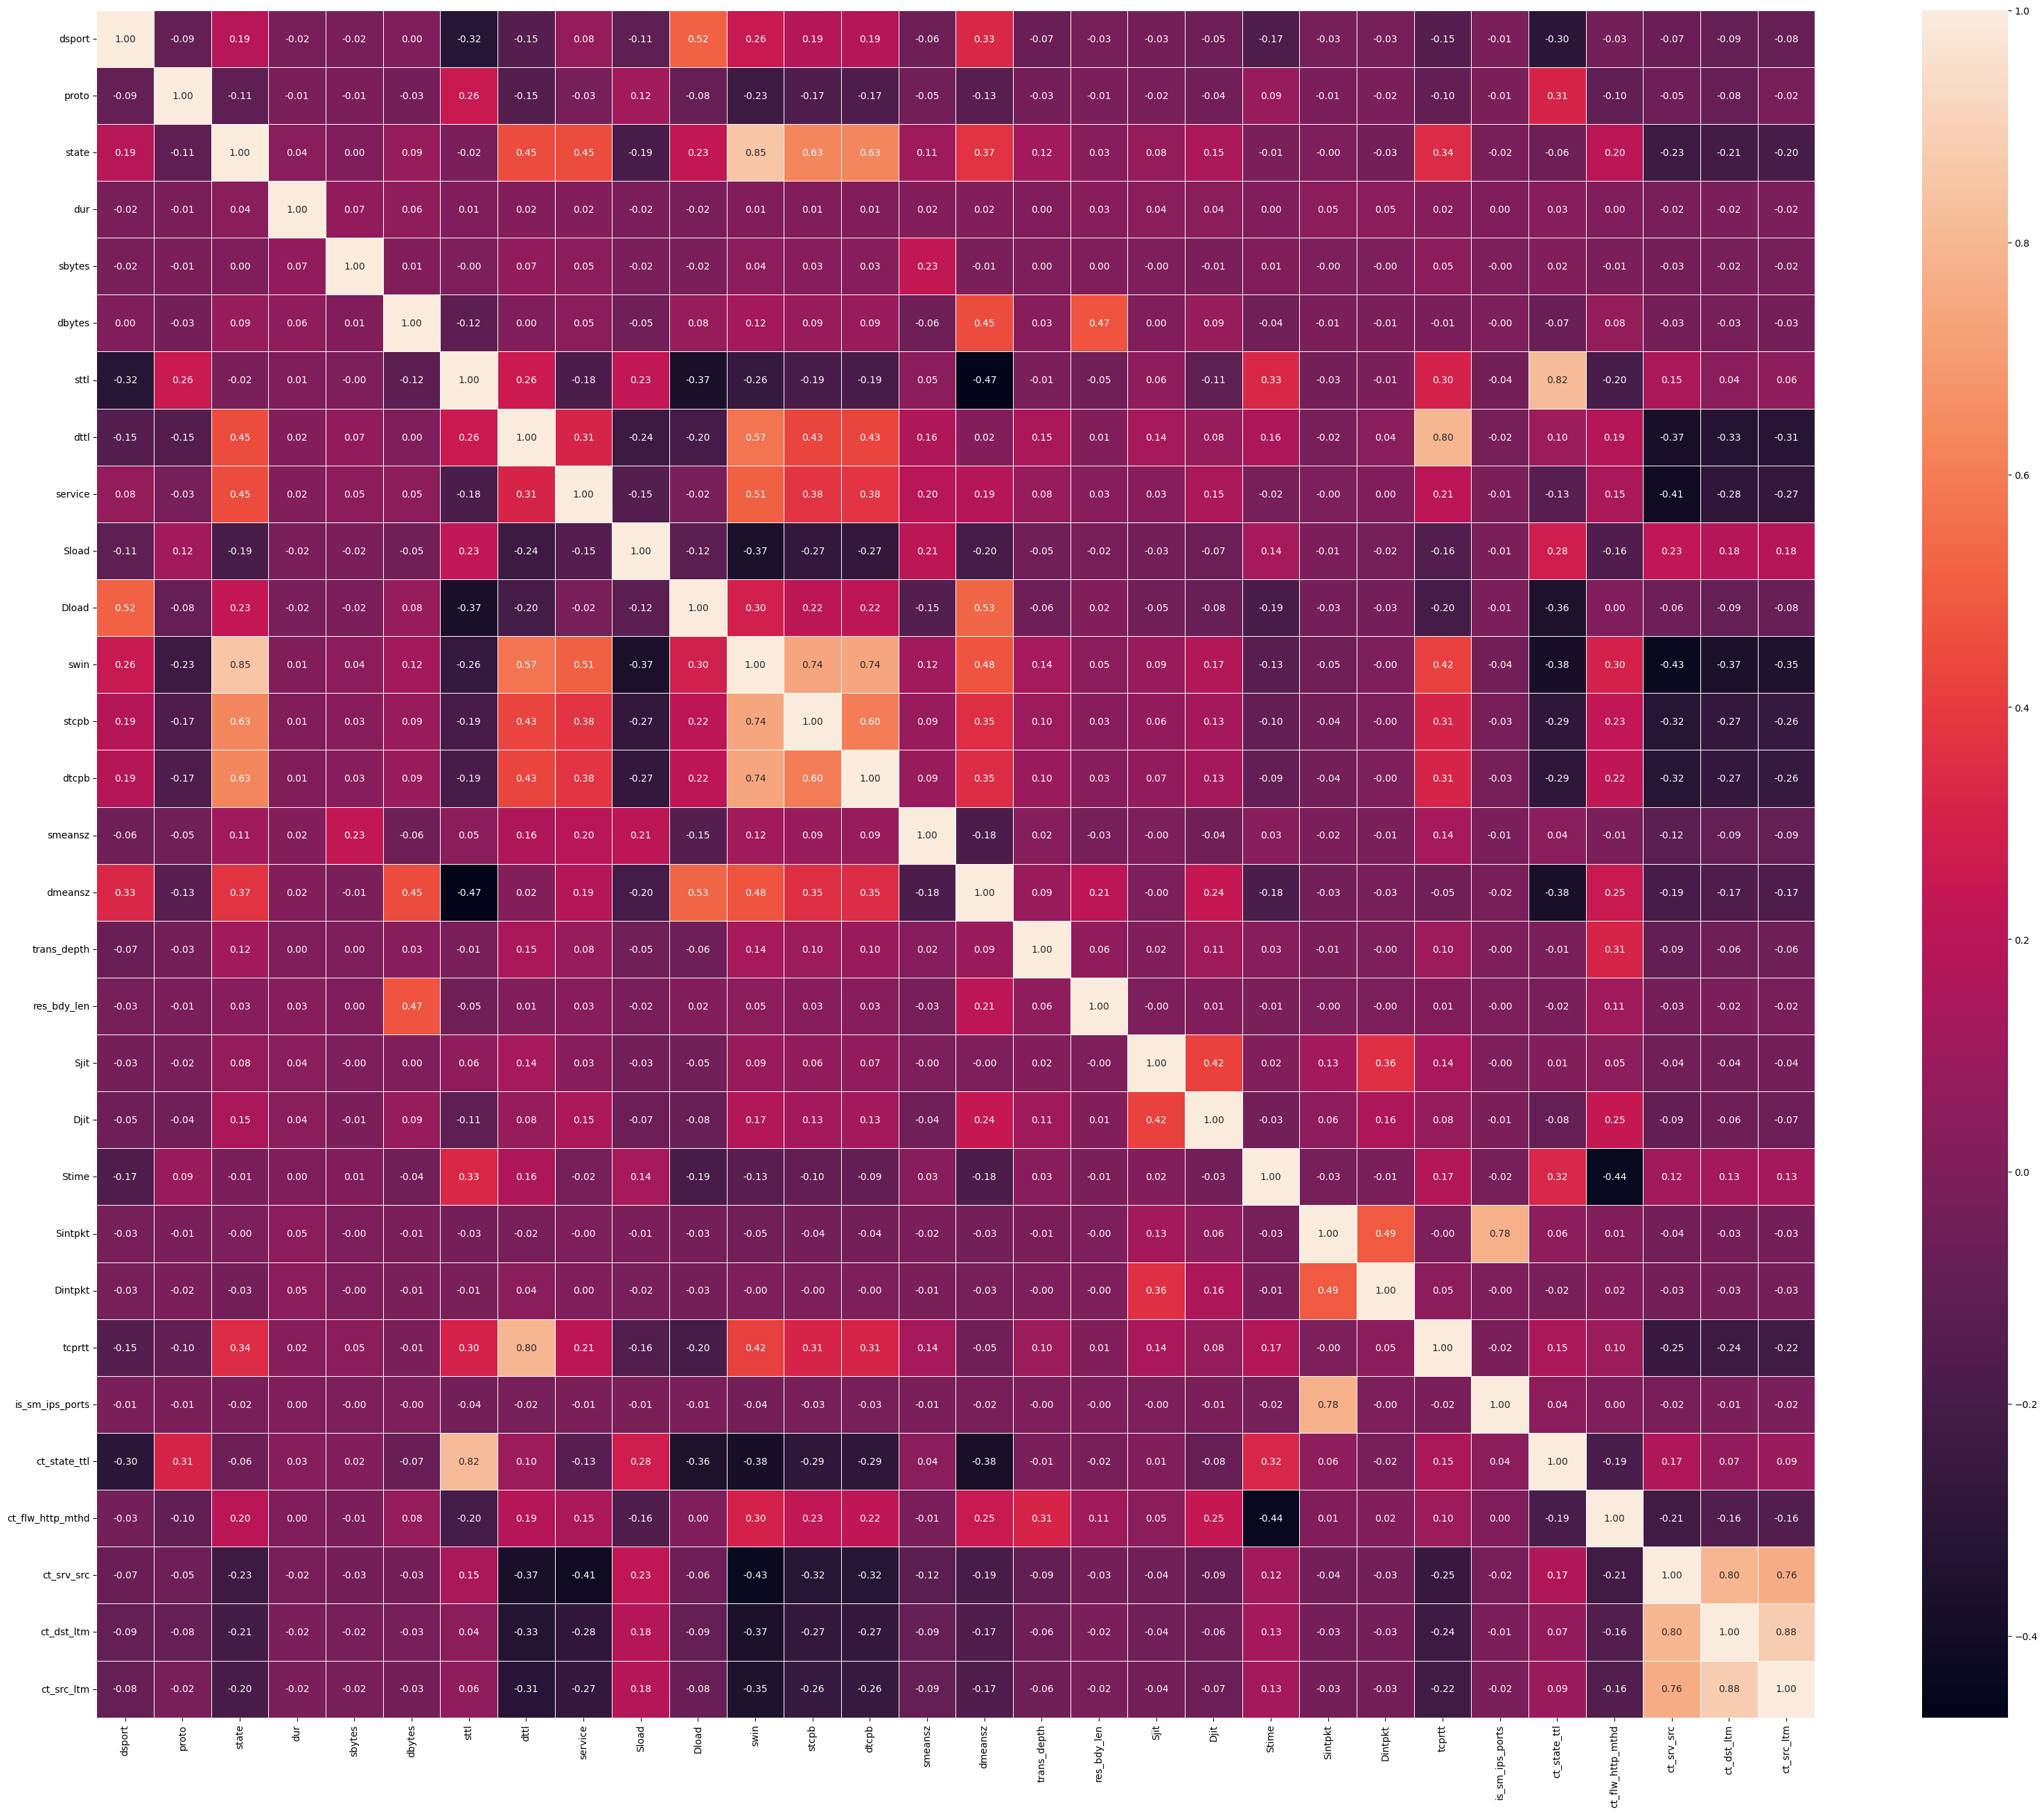

In [15]:
import numpy as np

abs_correlation_matrix = correlation_matrix.abs()

# Select upper triangle of correlation matrix
upper = abs_correlation_matrix.where(np.triu(np.ones(abs_correlation_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# print(to_drop)

# Drop features 
data.drop(to_drop, axis=1, inplace=True)

print(data.info())
f,ax = plt.subplots(figsize=(40,32))

data_without_label = data.drop(columns=['Label'])

correlation_matrix = data_without_label.corr()

sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

## Export preprocessed data to csv

In [16]:
data.to_csv("./../assets/UNSW-NB15-preprocessed.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199223 entries, 20 to 252672
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   dsport            199223 non-null  int64  
 1   proto             199223 non-null  int64  
 2   state             199223 non-null  int64  
 3   dur               199223 non-null  float64
 4   sbytes            199223 non-null  int64  
 5   dbytes            199223 non-null  int64  
 6   sttl              199223 non-null  int64  
 7   dttl              199223 non-null  int64  
 8   service           199223 non-null  int64  
 9   Sload             199223 non-null  float64
 10  Dload             199223 non-null  float64
 11  swin              199223 non-null  int64  
 12  stcpb             199223 non-null  int64  
 13  dtcpb             199223 non-null  int64  
 14  smeansz           199223 non-null  int64  
 15  dmeansz           199223 non-null  int64  
 16  trans_depth       1